# The Agent-Environment Interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment. 

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward (i.e. the **undiscounted return**) obtained by the two agents for each episode. This kind of graph is called a **learning curve**, and it gives us an idea of how our agent's performance changes during training.


## The agent-environment interface

<img src="img/agent-environment.png" style="width: 500px;" align="left"/> 

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 


## The environment: Navigation in a gridworld

<img src="img/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. If the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at a randomly selected initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-Learning
For your reference, the pseudocode for the Q-Learning algorithm is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).
<img src="img/q.png" style="width: 720px;"/>


### Example of a learning curve

<img src="img/lc_example.png" style="width: 550px;" align="left"/>

<br><br><br><br>

This is a sample learning curve and shows the reward obtained by a Q-learning agent across 500 episodes. Do not try to replicate this exact curve! It was computed using a different environment than the one described here.

In [36]:
import numpy as np

class GridworldQ:
    def __init__(self, rows, cols, random_move, unintended_action, bomb, gold):
        self.num_rows = rows
        self.num_cols = cols
        self.num_cells = self.num_cols * self.num_rows
        self.random_move_probability = random_move
        self.unintended_action = unintended_action
        
        # Choose starting position of the agent randomly among the first 5 cells
        self.agent_position = np.random.randint(0, 5)
        
        # Choose position of the gold and bomb
        self.bomb_positions = np.array([bomb])
        self.gold_positions = np.array([gold])
        self.terminal_states = np.array([self.bomb_positions, self.gold_positions])
       
        # Specify rewards
        self.rewards = np.zeros(self.num_cells)
        self.rewards[self.bomb_positions] = -10
        self.rewards[self.gold_positions] = 10
        
        # Specify available actions
        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        self.num_actions = len(self.actions)
        
        # Specify Q values
        self.q_values = [[0 for _ in range(self.num_actions)] for _ in range(self.num_cells)]
        self.alpha = 0.1
        
    def get_available_actions(self):
        """
        returns the available actions to the agent
        """
        
        return self.actions, self.neighbour_q_values(self.agent_position)
    
    def make_step(self, action_index): 
        # Randomly sample action_index if world is stochastic
        # randomness in agent's policy -> prob of exploring vs choosing greedily
        if np.random.uniform(0, 1) < self.random_move_probability:
            action_indices = np.arange(self.num_actions, dtype=int)
            action_indices = np.delete(action_indices, action_index)
            action_index = np.random.choice(action_indices, 1)[0]
        # randomness in environment -> unreliability of actions  
        elif np.random.uniform(0, 1) < self.unintended_action:
            action_indices = np.arange(self.num_actions, dtype=int)
            action_indices = np.delete(action_indices, action_index)
            action_index = np.random.choice(action_indices, 1)[0]

        action = self.actions[action_index]

        # Determine new position and check whether the agent hits a wall.
        old_position = self.agent_position
        new_position = self.agent_position
        if action == "UP":
            candidate_position = old_position + self.num_cols
            if candidate_position < self.num_cells:
                new_position = candidate_position
        elif action == "RIGHT":
            candidate_position = old_position + 1
            if candidate_position % self.num_cols > 0:  # The %-operator denotes "modulo"-division.
                new_position = candidate_position
        elif action == "DOWN":
            candidate_position = old_position - self.num_cols
            if candidate_position >= 0:
                new_position = candidate_position
        elif action == "LEFT":  # "LEFT"
            candidate_position = old_position - 1
            if candidate_position % self.num_cols < self.num_cols - 1:
                new_position = candidate_position
        else:
            raise ValueError('Action was mis-specified!')

        # Update the environment state
        self.agent_position = new_position
        
        # Calculate reward
        reward = self.rewards[self.agent_position]
        reward -= 1
        
        # Update Q values
        #action_index = self.actions.index(action)
        #neighbour_q = self.neighbour_q_values(old_position)
        neighbour_q = self.neighbour_q_values(new_position)
        if new_position != old_position:
            self.q_values[old_position][action_index] = (1 - self.alpha) * self.q_values[old_position][action_index] \
            + self.alpha * (reward + max(neighbour_q))
        
        return reward, new_position
    
    def neighbour_q_values(self, position):
        q_up = self.q_values[position][0]
        q_right = self.q_values[position][1]
        q_down = self.q_values[position][2]
        q_left = self.q_values[position][3]
        
        return [q_up, q_right, q_down, q_left]
    
    def is_goal(self):
        
        return self.agent_position in self.terminal_states
    
    def display_result(self):
        print("Episode ended, agent located at {}".format(env.agent_position))
        if self.agent_position == self.gold_positions:
            print("Yay! You found the gold")
        else:
            print("You found the bomb")
            
    def reset(self):
        self.agent_position = np.random.randint(0, 5)

In [37]:
class RandomAgentQ():
    def choose_action(self, available_actions, q_values):
        #number_of_actions = len(available_actions)
        #random_action_index = np.random.randint(0, number_of_actions)
        max_q_values = [i for i, x in enumerate(q_values) if x == max(q_values)]
        random_action_index = np.random.choice(max_q_values)
        
        return random_action_index

In [38]:
env = GridworldQ(5, 5, 0.05, 0.20, 18, 23)
agent = RandomAgentQ()

In [39]:
import time

start = time.time()

numEpisodes = 0
rewardEpisode = 0
rewardEpisodes = []
while numEpisodes < 500:
    while not env.is_goal():
        available_actions, q_values = env.get_available_actions()
        chosen_action = agent.choose_action(available_actions, q_values)
        reward, new_pos = env.make_step(chosen_action)
        rewardEpisode += reward
    rewardEpisodes.append(rewardEpisode)
    rewardEpisode = 0
    numEpisodes += 1
    env.display_result()
    env.reset()
    
print("Time taken: {}".format(time.time() - start))

Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent locate

Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 23
Yay! You found the gold
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 18
You found the bomb
Episode ended, agent located at 23
Yay! You found the gold
Episode ende

Terminal state is a roughly even split of 18 (bomb) and 23 (gold) for episodes early on but towards the end, it changes and the agent mainly ends in the 23 (gold) terminal state.

Text(0.5, 0, 'Episode Number')

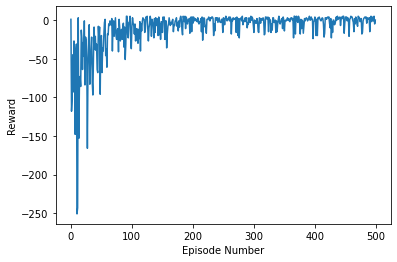

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rewardEpisodes)
plt.ylabel("Reward")
plt.xlabel("Episode Number")